# Criando um modelo de identificação de fraudes

**Origem da base de dados:** https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

**<u>Informações obtidas através do Kaggle</u>**

**Contexto**: 
É importante que as empresas de cartão de crédito reconheçam transações fraudulentas para que os clientes não sejam cobrados por itens que não compraram.

**Conteúdo**: 
O conjunto de dados contém transações feitas por cartões de crédito em setembro de 2013 por titulares de cartões europeus. Esse conjunto apresenta transações de dois dias, com 492 fraudes em um total de 284.807 transações. ***O conjunto de dados é altamente desbalanceado***, com a classe positiva (fraudes) representando 0,172% de todas as transações.

Ele contém apenas variáveis numéricas, que são o resultado de uma transformação PCA (Análise de Componentes Principais). Infelizmente, devido a questões de confidencialidade, não podemos fornecer as variáveis originais nem mais informações contextuais sobre os dados. As variáveis V1, V2, … V28 são os componentes principais obtidos com o PCA; as únicas variáveis que não foram transformadas são 'Time' e 'Amount'. A variável 'Time' indica o tempo em segundos decorrido entre cada transação e a primeira do conjunto de dados. A variável 'Amount' é o valor da transação, podendo ser utilizada para aprendizado sensível a custo dependente do exemplo. A variável 'Class' é a variável de resposta, sendo 1 em caso de fraude e 0 caso contrário.

**Objetivos**: 
- Testar diferentes métodos de balanceamento de dados, a fim de definir um método para para treinar os modelos de previsão cuja classe de Fraude e Não-Fraude estará adequadamente balanceada (50%-50%)
- Usar diferentes modelo de Classificação (Decision Tree, Logistic Regression, Support Vector Machine, KNearest Neighbors, Random Forest)
- Definir quais métricas serão mais importante avaliarmos par esse problema (Recall, por exemplo), e analisar gráficamente outras métricas como Curva ROC e Curva Precisão-Recall
- Simualar os custos que podemos ter com os diferentes modelos apresentando diferentes resultados de Precisão e Recall como forma de ajudar a escolher qual é o melhor modelo para a aplicação.

In [2]:
# Bibliotecas usadas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [3]:
# Modelos de Classificação usados
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Outras bibliotecas usadas
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss 
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

In [5]:
# Para filtrar os warnings que podem aparecer no arquivo
import warnings
warnings.filterwarnings('ignore')

## 1) Análise Exploratória dos Dados

In [6]:
# Importando a base de dados
transacoes = pd.read_csv('creditcard.csv')
display(transacoes)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [7]:
transacoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [8]:
# Verificando se há algum valor nulo nas colunas do dataframe
transacoes.isnull().sum().sum()

0

In [9]:
transacoes.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


***OBS: Podemos ver uma variabilidade dos dados muito maior para as colunas "Time" e "Amount", analisando como o desvio padrão dessas colunas é muito maior e a diferença dos valores mínimo e máximo também. Talvez seja interessante fazer o tratamento desses dados para não prejudicar nosso modelo de previsão de fraude***

In [10]:
# Verificando visualmente o % de transações que são fraude
transacoes['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [11]:
print("{:.2%} das transações é fraude".format(transacoes['Class'].sum()/transacoes['Class'].count()))

0.17% das transações é fraude


***OBS: Aqui já podemos ver quão desbalanceada é essa base de dados***

<Axes: ylabel='count'>

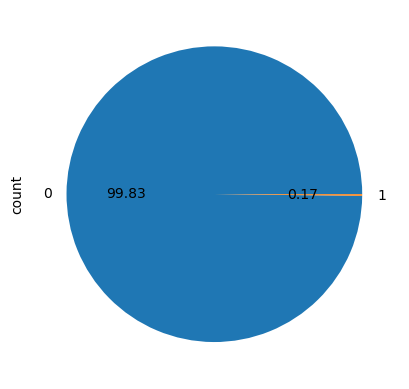

In [12]:
transacoes['Class'].value_counts().plot.pie(autopct='%.2f')

Text(0.5, 1.0, 'Correlação das variáveis do dataframe')

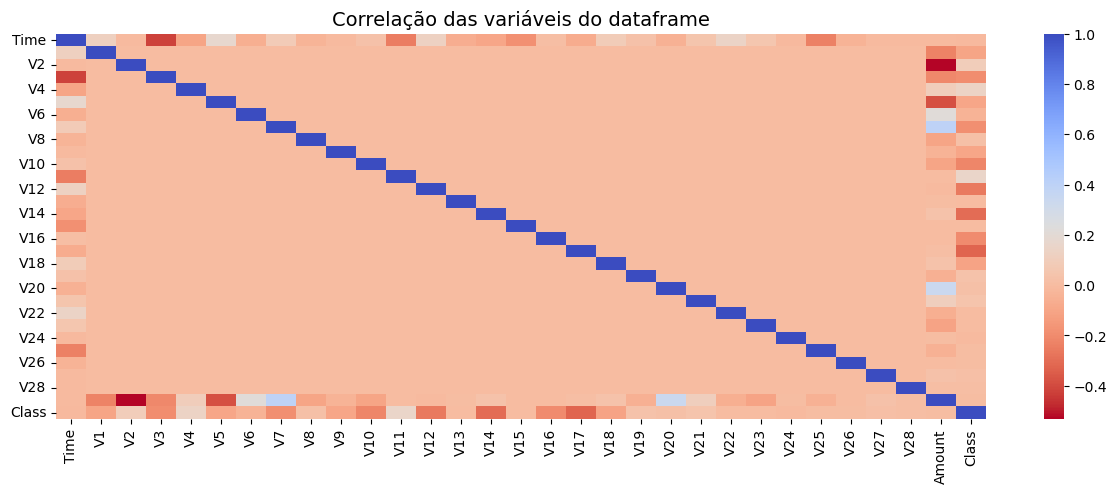

In [13]:
# Entendendo a correlação das features do dataframe

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,5))

# Entire DataFrame
corr = transacoes.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
ax.set_title("Correlação das variáveis do dataframe", fontsize=14)

## 2) Tratamento Inicial da Base de Dados

**Explicação do tratamento dos dados** - Como mencionado acima, as colunas Time e Amout são as que apresentam dados com uma variabilidade muito maior que as demais, e isso pode ser prejudicial pros modelos de previsão de dados que estaremos testando nesse notebook. Para reduzir esse efeito negativo, transformaremos os dados de ambas as colunas em valores que irão variar de 0 a 1.

In [14]:
transacoes.Time = transacoes.Time / transacoes.Time.max()

In [15]:
transacoes.Amount = transacoes.Amount / transacoes.Amount.max()

In [16]:
display(transacoes[['Time', 'Amount']])

,Time,Amount
0,0.000000,0.005824
1,0.000000,0.000105
2,0.000006,0.014739
3,0.000006,0.004807
4,0.000012,0.002724
...,...,...
284802,0.999965,0.000030
284803,0.999971,0.000965
284804,0.999977,0.002642
284805,0.999977,0.000389


## 3) Separando os dados em treino e teste

In [17]:
X = transacoes.drop('Class', axis=1)
y = transacoes['Class']

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)

**OBS:** Importante usados o parâmetro 'stratify=y' para que as bases y_train e y_test tenham uma proporção de classe similar

In [19]:
# Criando função para avaliar os modelos
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

def avaliar_modelo(y_test, y_pred):
    print(f'Acurácia: {accuracy_score(y_test, y_pred):.2%}')
    print(f'Precisão: {precision_score(y_test, y_pred):.2%}')
    print(f'Recall: {recall_score(y_test, y_pred):.2%}')
    print(f'Confusion_matrix: \n{confusion_matrix(y_test, y_pred)}')


## 4) Definindo um modelo de previsão de dados inicial 

Posteriormente iremos fazer tratamentos com nossa base de treino e iremos comparar quais destes tratamentos melhoraram os resultados, para então partir para a criação de mais modelos. 

In [20]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Avaliando o modelo
print('Modelo Inicial')
avaliar_modelo(y_test, y_pred)

Modelo Inicial
Acurácia: 99.92%
Precisão: 75.78%
Recall: 75.31%
Confusion_matrix: 
[[93786    39]
 [   40   122]]


## 5) Balanceando a classe dos valores que iremos prever

**Motivo:** Uma vez que temos a classe de dados fraude (1) e não fraude (0) difere muito uma da outra, haverá um tendência dos modelos preverem sempre a classe predominante, detectando transações fraudulentas como não fraude. Para treinar os modelos que testaremos nesse projeto, iremos balancear as classes fraude / não fraude.

**Métodos**: Para balanceamento das classes podemos usar métodos chamados "Undersampling", ou seja, reduzir a classe majoritária para ficar igual a minoritária, ou métodos "Oversmpling", que fazem o oposto.
- <u>Métodos Undersampling:</u> RandomUnderSampler, NearMiss, ClusterCentroids
- <u>Métodos Oversampling:</u> RandomOverSampler, SMOTE, ADASYN

#### 5A) RandomUndersampling

In [21]:
from imblearn.under_sampling import RandomUnderSampler

# Balanceando as classes
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# Retreinando o modelo e predizendo os dados
clfRU = tree.DecisionTreeClassifier(random_state=42).fit(X_train_res, y_train_res)
y_pred_RU = clfRU.predict(X_test)

# Avaliando o modelo
print('Modelo Inicial + RandomUnderSampler')
avaliar_modelo(y_test, y_pred_RU)

Modelo Inicial + RandomUnderSampler
Acurácia: 90.05%
Precisão: 1.55%
Recall: 90.74%
Confusion_matrix: 
[[84484  9341]
 [   15   147]]


#### 5B) NearMiss

In [22]:
from imblearn.under_sampling import NearMiss 

# Balanceando as classes
nm = NearMiss()
X_train_res_NM, y_train_res_NM = nm.fit_resample(X_train, y_train)

# Retreinando o modelo e predizendo os dados
clf_NM = tree.DecisionTreeClassifier(random_state=42).fit(X_train_res_NM, y_train_res_NM)
y_pred_NM = clf_NM.predict(X_test)

# Avaliando o modelo
print('Modelo Inicial + NearMiss')
avaliar_modelo(y_test, y_pred_NM)

Modelo Inicial + NearMiss
Acurácia: 5.43%
Precisão: 0.18%
Recall: 96.91%
Confusion_matrix: 
[[ 4948 88877]
 [    5   157]]


#### 5C) ClusterCentroids

In [23]:
from imblearn.under_sampling import ClusterCentroids

# Balanceando as classes
cc = ClusterCentroids(random_state=42)
X_train_res_CC, y_train_res_CC = cc.fit_resample(X_train, y_train)

# Retreinando o modelo e predizendo os dados
clf_CC = tree.DecisionTreeClassifier(random_state=42).fit(X_train_res_CC, y_train_res_CC)
y_pred_CC = clf_CC.predict(X_test)

# Avaliando o modelo
print('Modelo Inicial + ClusterCentroids')
avaliar_modelo(y_test, y_pred_CC)

Modelo Inicial + ClusterCentroids
Acurácia: 50.35%
Precisão: 0.32%
Recall: 93.21%
Confusion_matrix: 
[[47171 46654]
 [   11   151]]


#### 5D) RandomOversampling

In [24]:
from imblearn.over_sampling import RandomOverSampler

# Balanceando as classes
ros = RandomOverSampler(random_state=42, shrinkage=0.5)
X_train_res_RO, y_train_res_RO = ros.fit_resample(X_train, y_train)

# Retreinando o modelo e predizendo os dados
clfRO = tree.DecisionTreeClassifier(random_state=42).fit(X_train_res_RO, y_train_res_RO)
y_pred_RO = clfRO.predict(X_test)

# Avaliando o modelo
print('Modelo Inicial + RandomOverSampler')
avaliar_modelo(y_test, y_pred_RO)

Modelo Inicial + RandomOverSampler
Acurácia: 99.21%
Precisão: 16.06%
Recall: 84.57%
Confusion_matrix: 
[[93109   716]
 [   25   137]]


#### 5E) SMOTE

In [25]:
from imblearn.over_sampling import SMOTE

# Balanceando as classes
sm = SMOTE(random_state=42)
X_train_res_SM, y_train_res_SM = sm.fit_resample(X_train, y_train)

# Retreinando o modelo e predizendo os dados
clf_SM = tree.DecisionTreeClassifier(random_state=42).fit(X_train_res_SM, y_train_res_SM)
y_pred_SM = clf_SM.predict(X_test)

# Avaliando o modelo
print('Modelo Inicial + SMOTE')
avaliar_modelo(y_test, y_pred_SM)

Modelo Inicial + SMOTE
Acurácia: 99.74%
Precisão: 36.81%
Recall: 74.07%
Confusion_matrix: 
[[93619   206]
 [   42   120]]


#### 5F) ADASYN

In [26]:
from imblearn.over_sampling import ADASYN

# Balanceando as classes
ada = ADASYN(random_state=42)
X_train_res_ADA, y_train_res_ADA = ada.fit_resample(X_train, y_train)

# Retreinando o modelo e predizendo os dados
clf_ADA = tree.DecisionTreeClassifier(random_state=42).fit(X_train_res_ADA, y_train_res_ADA)
y_pred_ADA = clf_ADA.predict(X_test)

# Avaliando o modelo
print('Modelo Inicial + ADASYN')
avaliar_modelo(y_test, y_pred_ADA)

Modelo Inicial + ADASYN
Acurácia: 99.77%
Precisão: 40.55%
Recall: 72.84%
Confusion_matrix: 
[[93652   173]
 [   44   118]]


**Conclusão:** Entendendo o objetivo deste projeto, que é a detecção de fraudes em transações do cartão de crédito, é importante que nosso modelo tenha um bom Recall. Analisando os 6 métodos usados para fazer o resample dos dados, aquele que nos trouxe a melhor combinação entre Recall e Acurácia foi o *<u>RandomUnderSampling</u>* e é com esse método que seguiremos adiante nesse projeto ao analisar diferentes tipos de modelo de machine learning. Para esse modelo houve uma melhora de cerca de 15% tanto na acurácia quanto no recall em relação ao modelo inicial onde não havíamos treinado o modelo com o resample dos dados.

Text(0.5, 1.0, 'Correlação das variáveis do dataframe - Dataframe com as Classes Balanceadas')

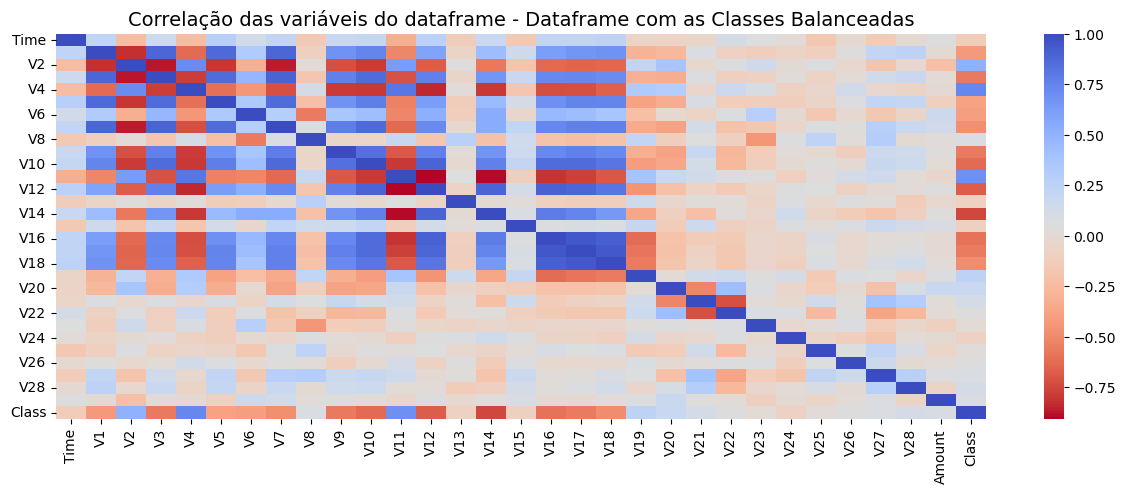

In [27]:
# Entendendo a correlação das features do dataframe após balanceamento

import seaborn as sns

fig, ax = plt.subplots(figsize=(15,5))

transacoes_balanceado = X_train_res.copy()
transacoes_balanceado['Class'] = y_train_res
transacoes_balanceado.head()

# Entire DataFrame
corr = transacoes_balanceado.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
ax.set_title("Correlação das variáveis do dataframe - Dataframe com as Classes Balanceadas", fontsize=14)

## 6) Testando diferentes Modelos de Machine Learning

Para esse projeto, iremos testar 5 modelos de machine learning diferentes para avaliar qual deles melhor se comporta para prever as fraudes do cartão de crédito. Todos serão treinados com os dados de treino balanceados através do RandomUnderSampler.

Esses modelos são:
- Decision Tree
- Linear Regression
- SVC
- KNN
- Random Forest

Para os modelos que estaremos treinando abaixo, além de tentar prever com os dados de X_test se cada transação é fraude ou não (classe 0 ou 1) com o y_pred, **também iremos prever a probabilidade de cada transação ser fraude, através do y_pred_proba** que é obtido através da função modelo.predict_proba(X_test).

É com essa variável y_pred_proba que faremos a análise da curva ROC 

#### 6A) DECISION TREE

In [28]:
# Treinando o modelo e prevendo os 
clf_AD = tree.DecisionTreeClassifier(random_state=42).fit(X_train_res, y_train_res)
y_pred_AD = clf_AD.predict(X_test)
y_pred_proba_AD = clf_AD.predict_proba(X_test)[:,1]

#### 6B) LOGISTIC REGRESSION

In [29]:
# Treinando o modelo e prevendo os dados
from sklearn.linear_model import LogisticRegression
clf_RL = LogisticRegression(random_state=42).fit(X_train_res, y_train_res)
y_pred_RL = clf_RL.predict(X_test)
y_pred_proba_RL = clf_RL.predict_proba(X_test)[:,1]

#### 6C) SUPPORT VECTOR MACHINE

In [30]:
# Treinando o modelo e prevendo os dados
from sklearn.svm import SVC
clf_SVC = SVC(random_state=0, probability=True).fit(X_train_res, y_train_res)
y_pred_SVC = clf_SVC.predict(X_test)
y_pred_proba_SVC = clf_SVC.predict_proba(X_test)[:,1]

#### 6D) KNN

In [31]:
# Treinando o modelo e prevendo os dados
from sklearn.neighbors import KNeighborsClassifier
clf_KNN = KNeighborsClassifier(n_neighbors=3).fit(X_train_res, y_train_res)
y_pred_KNN = clf_KNN.predict(X_test)
y_pred_proba_KNN = clf_KNN.predict_proba(X_test)[:,1]

#### 6E) RANDOM FOREST

In [32]:
# Treinando o modelo e prevendo os dados
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(max_depth=2, random_state=0).fit(X_train_res, y_train_res)
y_pred_RF = clf_RF.predict(X_test)
y_pred_proba_RF = clf_RF.predict_proba(X_test)[:,1]

## 7) Comparando os diferentes modelos

Além da análise dos modelos através das variáveis acurácia, precisão, recall e pela confusion_matrix, podemos comparar os modelos graficamente através da Precision-Recall Curve e calculando a área de baixo deessa curva (AUC)

#### 7A) Analisando parâmetros de acurácia, recall, precisão e a confusion matrix

In [33]:
print('----Decision Tree')
avaliar_modelo(y_test, y_pred_AD)
print("-"*30)

print('----Logistic Regression')
avaliar_modelo(y_test, y_pred_RL)
print("-"*30)

print('----SVC')
avaliar_modelo(y_test, y_pred_SVC)
print("-"*30)

print('----KNN')
avaliar_modelo(y_test, y_pred_KNN)
print("-"*30)

print('----Random Forest')
avaliar_modelo(y_test, y_pred_RF)

----Decision Tree
Acurácia: 90.05%
Precisão: 1.55%
Recall: 90.74%
Confusion_matrix: 
[[84484  9341]
 [   15   147]]
------------------------------
----Logistic Regression
Acurácia: 95.78%
Precisão: 3.59%
Recall: 90.74%
Confusion_matrix: 
[[89875  3950]
 [   15   147]]
------------------------------
----SVC
Acurácia: 98.49%
Precisão: 9.02%
Recall: 85.19%
Confusion_matrix: 
[[92433  1392]
 [   24   138]]
------------------------------
----KNN
Acurácia: 97.12%
Precisão: 5.18%
Recall: 90.74%
Confusion_matrix: 
[[91136  2689]
 [   15   147]]
------------------------------
----Random Forest
Acurácia: 99.27%
Precisão: 17.25%
Recall: 84.57%
Confusion_matrix: 
[[93168   657]
 [   25   137]]


#### 7B) Curva ROC

**OBS:** Para gerar os parâmetros para dessa curva é mais apropriado usar a variável y_pred_proba descrita anteriormente, que calcula a probabilidade de cada transação da base de teste (X_test) ser fraude ou não, do que a variável y_pred (que já determina à qual classe pertence - fraude ou não). Assim a curva gerada irá representar melhor a eficácia do modelo.

In [34]:
# Gerando os parâmetros da curva ROC
fpr_AD, tpr_AD, thresholdsD = metrics.roc_curve(y_test, y_pred_proba_AD)
fpr_RL, tpr_RL, thresholds_RL = metrics.roc_curve(y_test, y_pred_proba_RL)
fpr_SVC, tpr_SVC, thresholds_SVC = metrics.roc_curve(y_test, y_pred_proba_SVC)
fpr_KNN, tpr_KNN, thresholds_KNN = metrics.roc_curve(y_test, y_pred_proba_KNN)
fpr_RF, tpr_RF, thresholds_RF = metrics.roc_curve(y_test, y_pred_proba_RF)

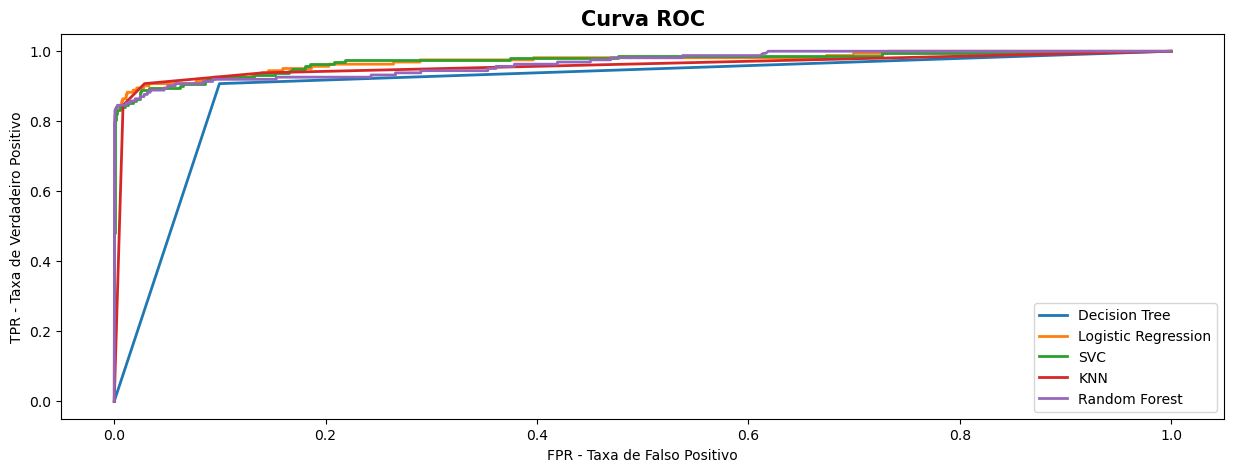

In [35]:
# Visualizando graficamente

fig, ax = plt.subplots(figsize=(15,5))

ax.plot(fpr_AD, tpr_AD, linewidth=2.0, label='Decision Tree')
ax.plot(fpr_RL, tpr_RL, linewidth=2.0, label='Logistic Regression')
ax.plot(fpr_SVC, tpr_SVC, linewidth=2.0, label='SVC')
ax.plot(fpr_KNN, tpr_KNN, linewidth=2.0, label='KNN')
ax.plot(fpr_RF, tpr_RF, linewidth=2.0, label='Random Forest')

ax.legend()
ax.set_title('Curva ROC', fontsize=15, fontweight='bold')
ax.set_ylabel('TPR - Taxa de Verdadeiro Positivo')
ax.set_xlabel('FPR - Taxa de Falso Positivo')
ax.grid(False)

plt.savefig("Curva ROC")
plt.show()

#### 7C) Precision-Recall Curve

**OBS:** Para gerar os parâmetros para dessa curva é mais apropriado usar a variável y_pred_proba descrita anteriormente, que calcula a probabilidade de cada transação da base de teste (X_test) ser fraude ou não, do que a variável y_pred (que já determina à qual classe pertence - fraude ou não). Assim a curva gerada irá representar melhor a eficácia do modelo.

In [36]:
# Gerando os parâmetros da curva precisão x recall
precision_AD, recall_AD, thresholds_AD = metrics.precision_recall_curve(y_test, y_pred_proba_AD)
precision_RL, recall_RL, thresholds_RL = metrics.precision_recall_curve(y_test, y_pred_proba_RL)
precision_SVC, recall_SVC, thresholds_SVC = metrics.precision_recall_curve(y_test, y_pred_proba_SVC)
precision_KNN, recall_KNN, thresholds_KNN = metrics.precision_recall_curve(y_test, y_pred_proba_KNN)
precision_RF, recall_RF, thresholds_RF = metrics.precision_recall_curve(y_test, y_pred_proba_RF)

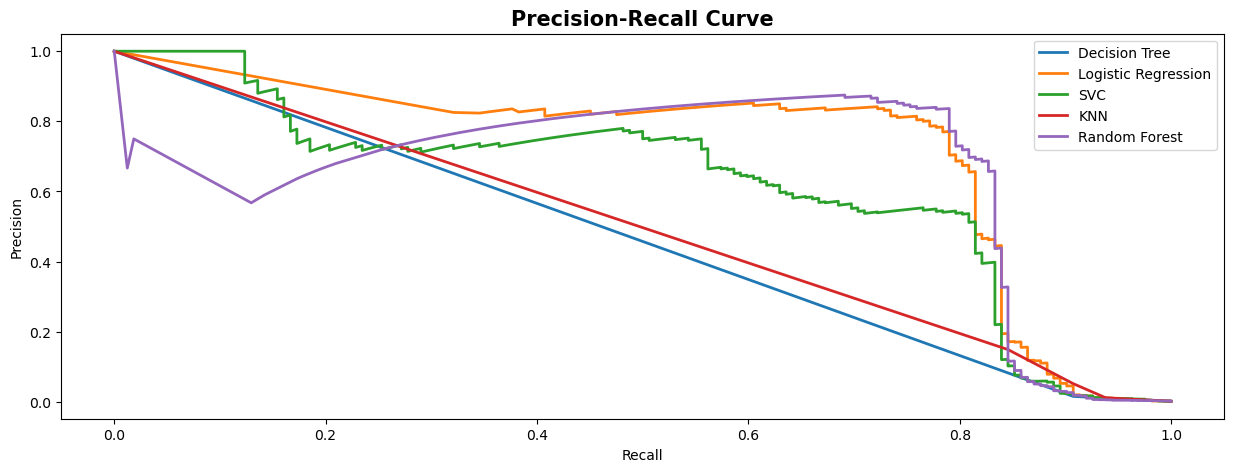

In [37]:
# Visualizando graficamente

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5))

ax.plot(recall_AD, precision_AD, linewidth=2.0, label='Decision Tree')
ax.plot(recall_RL, precision_RL, linewidth=2.0, label='Logistic Regression')
ax.plot(recall_SVC, precision_SVC, linewidth=2.0, label='SVC')
ax.plot(recall_KNN, precision_KNN, linewidth=2.0, label='KNN')
ax.plot(recall_RF, precision_RF, linewidth=2.0, label='Random Forest')

ax.legend()
ax.set_title('Precision-Recall Curve', fontsize=15, fontweight='bold')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.grid(False)

plt.savefig("Precision-Recall Curve")
plt.show()

#### 7C) AUC - Área de baixo da Curva Precision-Recall

In [38]:
print('Decision Tree')
print(metrics.auc(recall_AD, precision_AD))
print('Logistic Regression')
print(metrics.auc(recall_RL, precision_RL))
print('SVC')
print(metrics.auc(recall_SVC, precision_SVC))
print('KNN')
print(metrics.auc(recall_KNN, precision_KNN))
print('Random Forest')
print(metrics.auc(recall_RF, precision_RF))

Decision Tree
0.46153012929239556
Logistic Regression
0.7190152255881465
SVC
0.6152583149080748
KNN
0.49345655068764066
Random Forest
0.6504912358563952


**Análise dos Melhores Modelos:** 
- Pela AUC: Logistic Regression, Random Forest e SVC
- Pelo Recall e Acurácia: KNN, Logistic Regression e Decision Tree 

**Reflexao**: Qual é o objetivo do nosso modelo? Detectar fraudes no cartão de crédito. É importante que a tava da detecção das fraudes seja mais alta (Recall), mesmo que identifique como fraude transações verdadeiras, pois pode permitir uma segunda validação do cartão de crédito (inserir senha em um cartão de aproximação, ou alguma segunda validação da transação através de notificação pelo aplicativo do celular)

## 8) Testar diferentes parâmetros nos modelos 

Podemos testar a combinação de diferentes parâmetros para cada modelo realizado para verificar se houve uma melhora nos resultados antes de escolher qual é o melhor modelo para a nossa aplicação de detecção de fraude.
Para isso, usarei a ferramenta GridSearchCV do sklearn.

In [39]:
from sklearn.model_selection import GridSearchCV

#### 8A) DECISION TREE - Buscando melhores parâmetros


In [40]:
# Definindo os parâmetros
parametros = {
    'max_depth': [3,4,5,7,9],
    'splitter' : ['best', 'random'],
    'criterion' : ['gini', 'entropy', 'log_loss']}

# Treinando novamente o modelo
clf_AD_GS = GridSearchCV(tree.DecisionTreeClassifier(random_state=42), parametros, scoring=['recall','precision'], refit='recall')
clf_AD_GS = clf_AD_GS.fit(X_train_res, y_train_res)

# Prevendo dados
y_pred_AD_GS = clf_AD_GS.predict(X_test)
y_pred_proba_AD_GS = clf_AD_GS.predict_proba(X_test)[:,1]

In [41]:
clf_AD_GS.best_params_

{'criterion': 'gini', 'max_depth': 9, 'splitter': 'best'}

In [42]:
# Avaliando os novos resultados
print('----Decision Tree - Testando melhores parâmetros')

precision_AD_GS, recall_AD_GS, thresholds_AD_GS = metrics.precision_recall_curve(y_test, y_pred_proba_AD_GS)
print(f'AUC: {metrics.auc(recall_AD_GS, precision_AD_GS):.2f}')

avaliar_modelo(y_test, y_pred_AD_GS)
print("-"*30)

----Decision Tree - Testando melhores parâmetros
AUC: 0.46
Acurácia: 90.55%
Precisão: 1.64%
Recall: 91.36%
Confusion_matrix: 
[[84959  8866]
 [   14   148]]
------------------------------


#### 8B) LOGISTIC REGRESSION - Buscando melhores parâmetros

In [43]:
# Definindo os parâmetros
parametros = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg','lbfgs','liblinear','sag','saga']}

# Treinando novamente o modelo
clf_RL_GS = GridSearchCV(LogisticRegression(random_state=42),parametros, scoring=['recall','precision'], refit='recall')
clf_RL_GS = clf_RL_GS.fit(X_train_res, y_train_res)

# Prevendo dados
y_pred_RL_GS = clf_RL_GS.predict(X_test)
y_pred_proba_RL_GS = clf_RL_GS.predict_proba(X_test)[:,1]

In [44]:
clf_RL_GS.best_params_

{'C': 0.01, 'solver': 'liblinear'}

In [45]:
# Avaliando os novos resultados
print('----Logistic Regression - Testando melhores parâmetros')

precision_RL_GS, recall_RL_GS, thresholds_RL_GS = metrics.precision_recall_curve(y_test, y_pred_proba_RL_GS)
print(f'AUC: {metrics.auc(recall_RL_GS, precision_RL_GS):.2f}')

avaliar_modelo(y_test, y_pred_RL_GS)
print("-"*30)

----Logistic Regression - Testando melhores parâmetros
AUC: 0.69
Acurácia: 96.22%
Precisão: 3.96%
Recall: 90.12%
Confusion_matrix: 
[[90286  3539]
 [   16   146]]
------------------------------


#### 8C) SUPPORT VECTOR MACHINE - Buscando melhores parâmetros

In [46]:
# Definindo os parâmetros
parametros = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']}

# Treinando novamente o modelo
clf_SVC_GS = GridSearchCV(SVC(random_state=42, probability=True), parametros, scoring=['recall','precision'], refit='recall')
clf_SVC_GS = clf_SVC_GS.fit(X_train_res, y_train_res)

# Prevendo dados
y_pred_SVC_GS = clf_SVC_GS.predict(X_test)
y_pred_proba_SVC_GS = clf_SVC_GS.predict_proba(X_test)[:,1]


In [47]:
clf_SVC_GS.best_params_

{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}

In [48]:
print('----SVC - Testando melhores parâmetros')

precision_SVC_GS, recall_SVC_GS, thresholds_SVC_GS = metrics.precision_recall_curve(y_test, y_pred_proba_SVC_GS)
print(f'AUC: {metrics.auc(recall_SVC_GS, precision_SVC_GS):.2f}')

avaliar_modelo(y_test, y_pred_SVC_GS)
print("-"*30)

----SVC - Testando melhores parâmetros
AUC: 0.04
Acurácia: 89.96%
Precisão: 1.56%
Recall: 91.98%
Confusion_matrix: 
[[84402  9423]
 [   13   149]]
------------------------------


#### 8D) KNN - Buscando melhores parâmetros

In [49]:
# Definindo os parâmetros
parametros = {
    'n_neighbors': [3, 5, 7, 10, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

# Treinando novamente o modelo
clf_KNN_GS = GridSearchCV(KNeighborsClassifier(), parametros, scoring=['recall','precision'], refit='recall')
clf_KNN_GS = clf_KNN_GS.fit(X_train_res, y_train_res)

# Prevendo dados
y_pred_KNN_GS = clf_KNN_GS.predict(X_test)
y_pred_proba_KNN_GS = clf_KNN_GS.predict_proba(X_test)[:,1]

In [50]:
clf_KNN_GS.best_params_

{'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'}

In [51]:
print('----KNN - Testando melhores parâmetros')

precision_KNN_GS, recall_KNN_GS, thresholds_KNN_GS = metrics.precision_recall_curve(y_test, y_pred_proba_KNN_GS)
print(f'AUC: {metrics.auc(recall_KNN_GS, precision_KNN_GS):.2f}')

avaliar_modelo(y_test, y_pred_KNN_GS)

----KNN - Testando melhores parâmetros
AUC: 0.49
Acurácia: 97.12%
Precisão: 5.18%
Recall: 90.74%
Confusion_matrix: 
[[91136  2689]
 [   15   147]]


#### 8E) RANDOM FOREST - Buscando melhores parâmetros

In [52]:
# Definindo os parâmetros
parametros = {
    'max_depth': [3,4,5,7,9],
    'n_estimators' : [30,50,100,200],
    'criterion' : ['gini', 'entropy', 'log_loss']}

# Treinando novamente o modelo
clf_RF_GS = GridSearchCV(RandomForestClassifier(random_state=0), parametros, scoring=['recall','precision'], refit='recall')
clf_RF_GS = clf_RF_GS.fit(X_train_res, y_train_res)

# Prevendo dados
y_pred_RF_GS = clf_RF_GS.predict(X_test)
y_pred_proba_RF_GS = clf_RF_GS.predict_proba(X_test)[:,1]

In [53]:
clf_RF_GS.best_params_

{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 30}

In [54]:
print('----Random Forest - Testando melhores parâmetros')

precision_RF_GS, recall_RF_GS, thresholds_RF_GS = metrics.precision_recall_curve(y_test, y_pred_proba_RF_GS)
print(f'AUC: {metrics.auc(recall_RF_GS, precision_RF_GS):.2f}')

avaliar_modelo(y_test, y_pred_RF_GS)

----Random Forest - Testando melhores parâmetros
AUC: 0.71
Acurácia: 97.09%
Precisão: 5.03%
Recall: 88.89%
Confusion_matrix: 
[[91109  2716]
 [   18   144]]


#### 8F) Comparando os modelos novamente

In [55]:
print('Decision Tree - Testando melhores parâmetros')
fpr_AD_GS, tpr_AD_GS, thresholdsAD_GS = metrics.roc_curve(y_test, y_pred_proba_AD_GS)
precision_AD_GS, recall_AD_GS, thresholds_AD_GS = metrics.precision_recall_curve(y_test, y_pred_proba_AD_GS)
print(f'AUC: {metrics.auc(recall_AD_GS, precision_AD_GS):.2f}')
avaliar_modelo(y_test, y_pred_AD_GS)
print("-"*50)

print('Logistic Regression - Testando melhores parâmetros')
fpr_RL_GS, tpr_RL_GS, thresholds_RL_GS = metrics.roc_curve(y_test, y_pred_proba_RL_GS)
precision_RL_GS, recall_RL_GS, thresholds_RL_GS = metrics.precision_recall_curve(y_test, y_pred_proba_RL_GS)
print(f'AUC: {metrics.auc(recall_RL_GS, precision_RL_GS):.2f}')
avaliar_modelo(y_test, y_pred_RL_GS)
print("-"*50)

print('SVC - Testando melhores parâmetros')
fpr_SVC_GS, tpr_SVC_GS, thresholds_SVC_GS = metrics.roc_curve(y_test, y_pred_proba_SVC_GS)
precision_SVC_GS, recall_SVC_GS, thresholds_SVC_GS = metrics.precision_recall_curve(y_test, y_pred_proba_SVC_GS)
print(f'AUC: {metrics.auc(recall_SVC_GS, precision_SVC_GS):.2f}')
avaliar_modelo(y_test, y_pred_SVC_GS)
print("-"*50)

print('KNN - Testando melhores parâmetros')
fpr_KNN_GS, tpr_KNN_GS, thresholds_KNN_GS = metrics.roc_curve(y_test, y_pred_proba_KNN_GS)
precision_KNN_GS, recall_KNN_GS, thresholds_KNN_GS = metrics.precision_recall_curve(y_test, y_pred_proba_KNN_GS)
print(f'AUC: {metrics.auc(recall_KNN_GS, precision_KNN_GS):.2f}')
avaliar_modelo(y_test, y_pred_KNN_GS)
print("-"*50)

print('Random Forest - Testando melhores parâmetros')
fpr_RF_GS, tpr_RF_GS, thresholds_RF_GS = metrics.roc_curve(y_test, y_pred_proba_RF_GS)
precision_RF_GS, recall_RF_GS, thresholds_RF_GS = metrics.precision_recall_curve(y_test, y_pred_proba_RF_GS)
print(f'AUC: {metrics.auc(recall_RF_GS, precision_RF_GS):.2f}')
avaliar_modelo(y_test, y_pred_RF_GS)

Decision Tree - Testando melhores parâmetros
AUC: 0.46
Acurácia: 90.55%
Precisão: 1.64%
Recall: 91.36%
Confusion_matrix: 
[[84959  8866]
 [   14   148]]
--------------------------------------------------
Logistic Regression - Testando melhores parâmetros
AUC: 0.69
Acurácia: 96.22%
Precisão: 3.96%
Recall: 90.12%
Confusion_matrix: 
[[90286  3539]
 [   16   146]]
--------------------------------------------------
SVC - Testando melhores parâmetros
AUC: 0.04
Acurácia: 89.96%
Precisão: 1.56%
Recall: 91.98%
Confusion_matrix: 
[[84402  9423]
 [   13   149]]
--------------------------------------------------
KNN - Testando melhores parâmetros
AUC: 0.49
Acurácia: 97.12%
Precisão: 5.18%
Recall: 90.74%
Confusion_matrix: 
[[91136  2689]
 [   15   147]]
--------------------------------------------------
Random Forest - Testando melhores parâmetros
AUC: 0.71
Acurácia: 97.09%
Precisão: 5.03%
Recall: 88.89%
Confusion_matrix: 
[[91109  2716]
 [   18   144]]


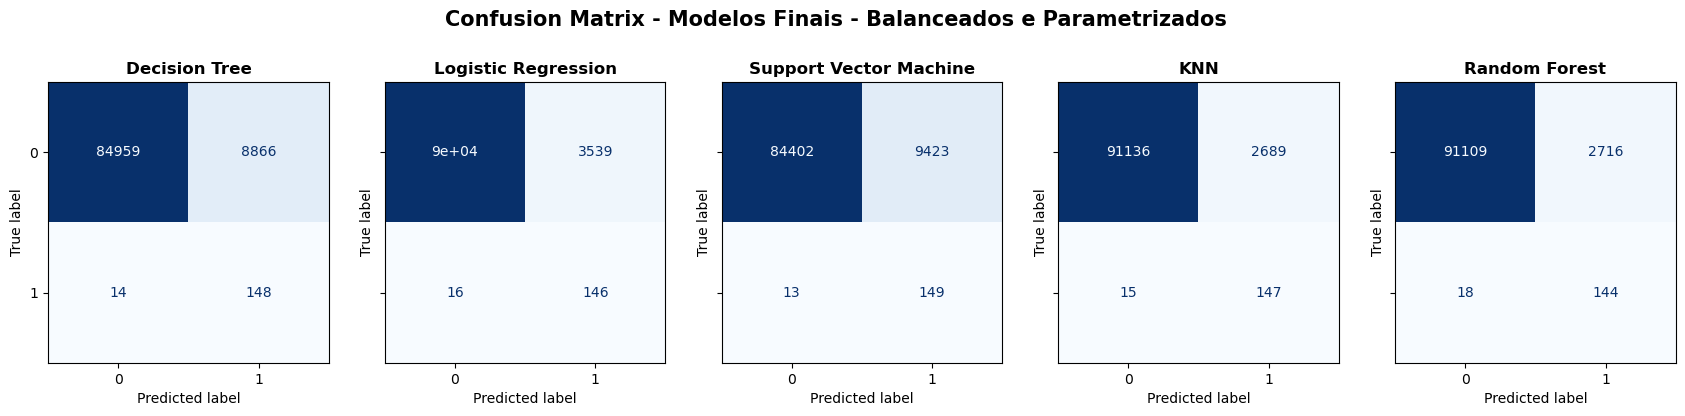

In [66]:
from sklearn.metrics import ConfusionMatrixDisplay

confusion_matrix_AD_GS = confusion_matrix(y_test, y_pred_AD_GS)
confusion_matrix_RL_GS = confusion_matrix(y_test, y_pred_RL_GS)
confusion_matrix_SVC_GS = confusion_matrix(y_test, y_pred_SVC_GS)
confusion_matrix_KNN_GS = confusion_matrix(y_test, y_pred_KNN_GS)
confusion_matrix_RF_GS = confusion_matrix(y_test, y_pred_RF_GS)

confusion_matrix_modelos = [confusion_matrix_AD_GS, confusion_matrix_RL_GS, confusion_matrix_SVC_GS, confusion_matrix_KNN_GS, confusion_matrix_RF_GS]
modelos = ['Decision Tree', 'Logistic Regression', 'Support Vector Machine', 'KNN', 'Random Forest']

fig, axes = plt.subplots(1, 5, figsize=(21, 5), sharey=True)

for i, (cm, modelo) in enumerate(zip(confusion_matrix_modelos, modelos)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(modelo, fontweight='bold')

plt.suptitle('Confusion Matrix - Modelos Finais - Balanceados e Parametrizados', fontsize=15, fontweight='bold')
plt.subplots_adjust(top=1)

plt.savefig("Confusion Matrix - Modelos Finais.png")

plt.show()

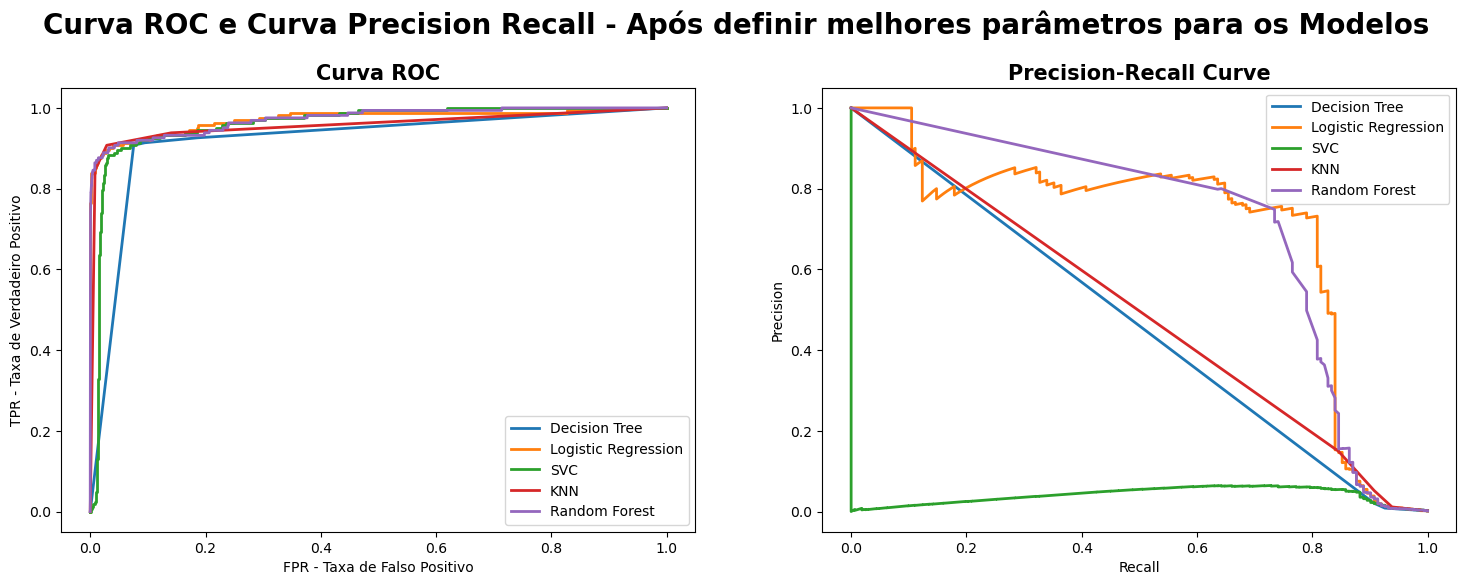

In [94]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

#Gráfico da Curva ROC
ax[0].plot(fpr_AD_GS, tpr_AD_GS, linewidth=2.0, label='Decision Tree')
ax[0].plot(fpr_RL_GS, tpr_RL_GS, linewidth=2.0, label='Logistic Regression')
ax[0].plot(fpr_SVC_GS, tpr_SVC_GS, linewidth=2.0, label='SVC')
ax[0].plot(fpr_KNN_GS, tpr_KNN_GS, linewidth=2.0, label='KNN')
ax[0].plot(fpr_RF_GS, tpr_RF_GS, linewidth=2.0, label='Random Forest')

ax[0].legend()
ax[0].set_title('Curva ROC', fontsize=15, fontweight='bold')
ax[0].set_ylabel('TPR - Taxa de Verdadeiro Positivo')
ax[0].set_xlabel('FPR - Taxa de Falso Positivo')
ax[0].grid(False)

#Gráfico da Precision-Curve
ax[1].plot(recall_AD_GS, precision_AD_GS, linewidth=2.0, label='Decision Tree')
ax[1].plot(recall_RL_GS, precision_RL_GS, linewidth=2.0, label='Logistic Regression')
ax[1].plot(recall_SVC_GS, precision_SVC_GS, linewidth=2.0, label='SVC')
ax[1].plot(recall_KNN_GS, precision_KNN_GS, linewidth=2.0, label='KNN')
ax[1].plot(recall_RF_GS, precision_RF_GS, linewidth=2.0, label='Random Forest')

ax[1].legend()
ax[1].set_title('Precision-Recall Curve', fontsize=15, fontweight='bold')
ax[1].set_ylabel('Precision')
ax[1].set_xlabel('Recall')
ax[1].grid(False)

plt.suptitle('Curva ROC e Curva Precision Recall - Após definir melhores parâmetros para os Modelos', fontsize=20, fontweight='bold')
plt.subplots_adjust(top=0.85)

#plt.savefig("Curva ROC")

**Análise dos novos resultados:** 

- **Modelo Decision Tree**: melhorou tanto o recall quanto a precisão com esses novos parâmetros
- **Modelos de Logistic Regression**: não teve melhoras significativas com esses novos parâmetros, tendo reduzido o recall até.
- **Modelo Support Vector Machine**: melhorou o recall e piorou a precisão
- **Modelo Random Forest**: tambem melhorou o recall mas piorando a precisão
- **Modelo KNN**: resultados não mudaram após teste com vários parâmetros, e vem sendo o modelo que apresenta o melhor recall com uma precisão similar aos demais modelos 

**CONCLUSÕES**
- O fato dos resultados não tiverem apresentado melhoras significativas demonstram um indício de OVERFITTING dos dados com a base de treino nos modelos, e quando isso se aplica na base de teste não se traduz em melhores resultados.

- Para decidir qual é o melhor modelo para essa aplicação, temos que entender qual variáveis será mais importante. Para evitar que transações fraudulentas não sejam detectadas, o que pode gerar custos para a companhia de crédito, aumentar o Recall ao máximo pode ser o objetivo principal. No entanto, ter muitas transações consideradas fraudelentas erroneamente (precisão baixa), pode acarretar em custos de verificação para a companhia de crédito também, que obviamente serão menores do que os custos de um transação fraudulenta não detectada.

- Como sugestão, podemos trabalhar com diferntes modelos dependendo do valor da transação. Transações cujo valor mais alto devem ter modelos cujo recall é maior, mesmo penalizando um pouco a precisão, para permitir que outras verificações sejam feitas no momento da transação é realizada como forma de validação. Transações mais baixas podem ter modelos cujo recall pode ser ligeiramente menor mas com uma precisão maior.

- Na escolha do melhor modelo para essa aplicação deve-se levar em conta o custo de não detecção de uma fraude ("taxa falso negativo"), e o custo da sinalização errônea de uma fraude em transações veríficas ("taxa falso positivo").

## 9) Simulando Custo dos Modelos

Outro critério que pode ser adotado para escolha do modelo mais adequado é estimar o custo que cada modelo pode gerar ao classificar erroneamente transações do cartão de crédito. Para isso, vamos considerar que cada fraude não detectada pode gerar um impacto financeiro para a companhia de crédito de R$ 8500 , e o custo da verificação com o cliente se a transação é fraudulenta ou não é de R$ 1,50. Com esses dados, podemos estimar o "custo do erro" de cada modelo

In [95]:
# Custo da não detecção de fraude 
preco_fraude = 8500

# Custo da verificação da transação
preco_verificacao = 2.50

#### 9A) Simulando Custos - Decision Tree

In [96]:
CM = confusion_matrix(y_test, y_pred_AD_GS)

print(f"Fraudes Não Detectadas: {CM[1][0]}")
print(f"Fraudes Detectadas Erroneamente (não era fraude): {CM[0][1]}")

Custo_Erro_AD = CM[1][0]*preco_fraude + CM[0][1]*preco_verificacao
print(f"Custo do 'Erro' - Modelo Decision Tree: R$ {Custo_Erro_AD}")

Fraudes Não Detectadas: 14
Fraudes Detectadas Erroneamente (não era fraude): 8866
Custo do 'Erro' - Modelo Decision Tree: R$ 141165.0


#### 9B) Simulando Custos - Logistic Regression

In [97]:
CM = confusion_matrix(y_test, y_pred_RL_GS)

print(f"Fraudes Não Detectadas: {CM[1][0]}")
print(f"Fraudes Detectadas Erroneamente (não era fraude): {CM[0][1]}")

Custo_Erro_RL = CM[1][0]*preco_fraude + CM[0][1]*preco_verificacao
print(f"Custo do 'Erro' - Modelo Logistic Regression: R$ {Custo_Erro_RL}")

Fraudes Não Detectadas: 16
Fraudes Detectadas Erroneamente (não era fraude): 3539
Custo do 'Erro' - Modelo Logistic Regression: R$ 144847.5


#### 9C) Simulando Custos - Support Vector Machine

In [98]:
CM = confusion_matrix(y_test, y_pred_SVC_GS)

print(f"Fraudes Não Detectadas: {CM[1][0]}")
print(f"Fraudes Detectadas Erroneamente (não era fraude): {CM[0][1]}")

Custo_Erro_SVM = CM[1][0]*preco_fraude + CM[0][1]*preco_verificacao
print(f"Custo do 'Erro' - Modelo SVC: R$ {Custo_Erro_SVM}")

Fraudes Não Detectadas: 13
Fraudes Detectadas Erroneamente (não era fraude): 9423
Custo do 'Erro' - Modelo SVC: R$ 134057.5


#### 9D) Simulando Custos - KNN

In [99]:
CM = confusion_matrix(y_test, y_pred_KNN_GS)

print(f"Fraudes Não Detectadas: {CM[1][0]}")
print(f"Fraudes Detectadas Erroneamente (não era fraude): {CM[0][1]}")

Custo_Erro_KNN = CM[1][0]*preco_fraude + CM[0][1]*preco_verificacao
print(f"Custo do 'Erro' - Modelo KNN: R$ {Custo_Erro_KNN}")

Fraudes Não Detectadas: 15
Fraudes Detectadas Erroneamente (não era fraude): 2689
Custo do 'Erro' - Modelo KNN: R$ 134222.5


#### 9E) Simulando Custos - Random Forest

In [100]:
CM = confusion_matrix(y_test, y_pred_RF_GS)

print(f"Fraudes Não Detectadas: {CM[1][0]}")
print(f"Fraudes Detectadas Erroneamente (não era fraude): {CM[0][1]}")

Custo_Erro_RF = CM[1][0]*preco_fraude + CM[0][1]*preco_verificacao
print(f"Custo do 'Erro' - Modelo KNN: R$ {Custo_Erro_RF}")

Fraudes Não Detectadas: 18
Fraudes Detectadas Erroneamente (não era fraude): 2716
Custo do 'Erro' - Modelo KNN: R$ 159790.0


In [101]:
Modelos = ['Decision Tree', 'Logistic Regression', 'SVM', 'KNN', 'Random Forest']
Custos = [Custo_Erro_AD, Custo_Erro_RL, Custo_Erro_SVM, Custo_Erro_KNN, Custo_Erro_RF]

df_custos = pd.DataFrame({'Modelo': Modelos, 'Custo do Erro': Custos})
df_custos

,Modelo,Custo do Erro
0,Decision Tree,141165.0
1,Logistic Regression,144847.5
2,SVM,134057.5
3,KNN,134222.5
4,Random Forest,159790.0


#### Verificando graficamente

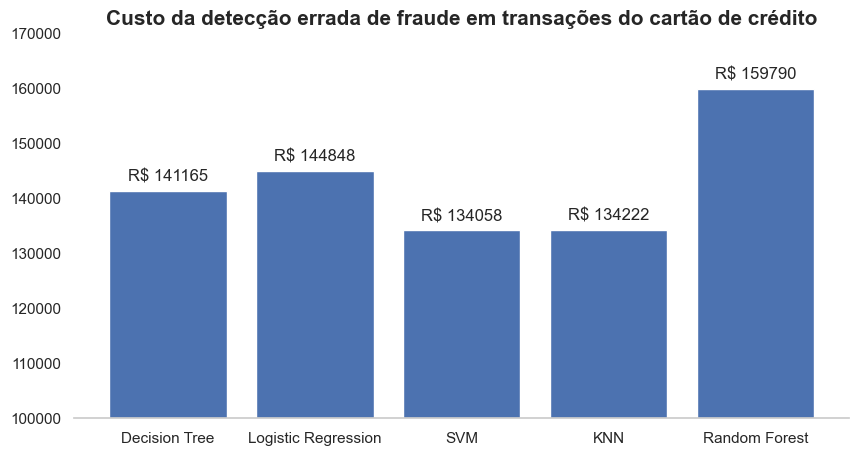

In [ ]:
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(10,5))

bars = ax.bar(df_custos['Modelo'], df_custos['Custo do Erro'], color=sns.color_palette("muted"))

ax.bar(df_custos['Modelo'], df_custos['Custo do Erro'])

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'R$ {height:.0f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # Pequeno deslocamento acima da barra
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_title('Custo da detecção errada de fraude em transações do cartão de crédito', fontsize=15, fontweight='bold')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
ax.set_ylim(100000, 170000)

plt.savefig("Custo de Deteccao Errada de Fraudes")

plt.show()

**Concluindo**: Baseado nestes custos da detecção errada de fraudes, os modelos Support Vector Machine e o KNN são os que apresentaram melhores resultados.